# Introduction

Once we have our expression matrix, it should be examined to remove poor quality cells which were not detected in the initial processing of the raw reads. Failure to remove low quality cells at this
stage may add technical noise which has the potential to obscure
the biological signals of interest in the downstream analysis. 

Since there is currently no standard method for performing scRNAseq, the expected values for the various QC measures that will be presented here can vary substantially from experiment to experiment. Thus, to perform QC we will be looking for cells which are outliers with respect to the rest of the dataset rather than comparing to independent quality standards. Consequently, care should be taken when comparing quality metrics across datasets collected using different protocols.


#  Dataset

We'll continue working with the Tabula Muris brain data that we prepared earlier: 

In [1]:
import scanpy as sc # import scanpy to handle our AnnData 
import pandas as pd # import pandas to handle dataframes
import matplotlib.pyplot as plt # import matplotlib to visualize our qc metrics

# magic incantation to help matplotlib work with our jupyter notebook
%matplotlib inline 

In [2]:
adata = sc.read('../data/brain_raw.h5ad')

## Computing quality control metrics 
We'll compute quality metrics and then filter cells and genes accordingly.

The `calculate_qc_metrics` function returns two dataframes: one containing quality control metrics about cells, and one containing metrics about genes. This function is housed in the 'preprocessing' portion of the SCANPY library, which you can read more about [here](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/index.html#module-scanpy.pp).

In [4]:
qc = sc.pp.calculate_qc_metrics(adata, qc_vars = ['ERCC'])# this returns a tuple of (cell_qc_dataframe, gene_qc_dataframe)
                                 # ask for the percentage of reads from spike ins
                                
cell_qc_dataframe = qc[0]
gene_qc_dataframe = qc[1]

print('This is the cell quality control dataframe:')
print(cell_qc_dataframe.head())

print('\n\nThis is the gene quality control dataframe')
print(gene_qc_dataframe)

This is the cell quality control dataframe:
                         n_genes_by_counts  log1p_n_genes_by_counts  \
index                                                                 
A1.B003290.3_38_F.1.1                 3359                 8.119696   
A1.B003728.3_56_F.1.1                 1718                 7.449498   
A1.MAA000560.3_10_M.1.1               3910                 8.271548   
A1.MAA000564.3_10_M.1.1               4352                 8.378621   
A1.MAA000923.3_9_M.1.1                2248                 7.718241   

                         total_counts  log1p_total_counts  \
index                                                       
A1.B003290.3_38_F.1.1        390075.0           12.874097   
A1.B003728.3_56_F.1.1        776439.0           13.562474   
A1.MAA000560.3_10_M.1.1     1616087.0           14.295519   
A1.MAA000564.3_10_M.1.1      360004.0           12.793873   
A1.MAA000923.3_9_M.1.1       290282.0           12.578611   

                         pct_c

# Quality control for cells

## Library size
First, we consider the total number of reads detected per cell.
Cells with few reads are likely to have been broken or failed to capture a cell, and should thus be removed.

(0, 1000000.0)

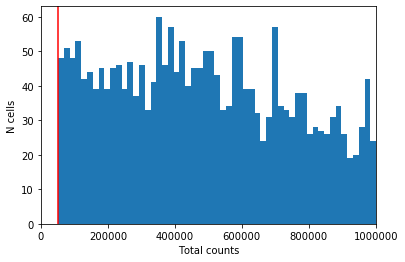

In [5]:
plt.hist(cell_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('N cells')
plt.axvline(50000, color='red')
plt.xlim(0,1e6) # Try plotting with and without scaling the x-axis. When is this helpful?

We have a few cells with fewer than 50,000 reads; we'll remove these downstream. 

## Detected genes

In addition to ensuring sufficient sequencing depth for each sample, we also want to make sure that the reads are distributed across the transcriptome. Thus, we count the total number of unique genes detected in each sample.

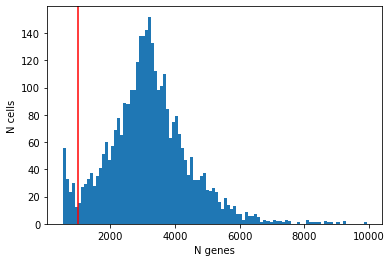

In [6]:
plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axvline(1000, color='red')

From the plot we conclude that most cells have between ~1,000-5,000 detected genes,
which is typical for smartseq2 data. However, this varies by
experimental protocol and sequencing depth. 

The most notable feature in the above plot is the little peak on the left hand side of the
distribution. If detection rates were equal across the cells then the
distribution should be approximately normal. Thus, we will remove those
cells in the tail of the distribution (fewer than ~1000 detected genes).

## Spike-ins

Another measure of cell quality is the ratio between ERCC spike-in RNAs and endogenous RNAs. This ratio can be used to estimate the total amount of RNA in the captured cells. Cells with a high level of spike-in RNAs had low starting amounts of RNA, likely due to the cell being dead or stressed which may result in the RNA being degraded.

### Exercise  

Plot the distribution of `pct_counts_ERCC` in this dataset. What do you think is a reasonable threshold? 

<p>
<details>
<summary><h3>Solution</h3></summary>
<code>plt.hist(cell_qc_dataframe['pct_counts_ERCC'], bins=1000)
plt.xlabel('Percent counts ERCC')
plt.ylabel('N cells')
plt.axvline(10, color='red')</code>
<p>    
Placing a threshold is always a judgement call. Here, the majority of cells have less than 10% ERCC counts, but there's a long tail of cells that have very high spike-in counts; these are likely dead cells and should be removed. 
</details>

## Cell filtering

Now we can define a cell filter based on our findings:

There isn't an automatic function for removing cells with a high percentage of ERCC reads, but we can use a _mask_ to remove them like so:

In [7]:
low_ERCC_mask = (cell_qc_dataframe['pct_counts_ERCC'] < 10)
adata = adata[low_ERCC_mask]

### Exercise  

Use the SCANPY function `sc.pp.filter_cells()` to filter cells with fewer than 50,000 reads. Repeat to remove those with fewer than 750 genes detected. How many cells does this remove?  
_Hint: start with the Parameters list in `help(sc.pp.filter_cells)`

<p>
<details>
<summary><h3>Solution</h3></summary>
<code>print('Started with: \n', adata)
sc.pp.filter_cells(adata, min_genes = 750)
sc.pp.filter_cells(adata, min_counts = 50000)
print('Finished with: \n', adata)</code>
</details>

## Quality control for genes

It is typically a good idea to remove genes whose expression level is considered __"undetectable"__. We define a gene as  detectable if at least two cells contain more than 5 reads from the gene. However, the threshold strongly depends on the sequencing depth. It is important to keep in mind that genes must be filtered after cell filtering since some genes may only be detected in poor quality cells.

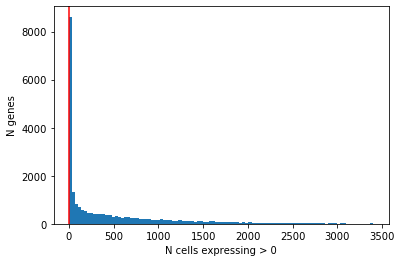

In [9]:
plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=100)
plt.xlabel('N cells expressing > 0')
plt.ylabel('N genes')
plt.axvline(2, color='red')

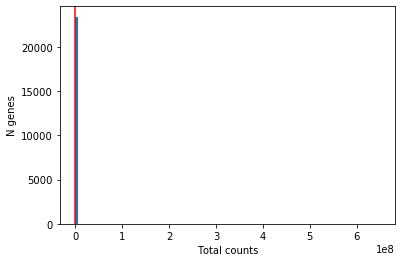

In [27]:
plt.hist(gene_qc_dataframe['total_counts'], bins=100)
plt.xlabel('Total counts')
plt.ylabel('N genes')

plt.axvline(10, color='red')
# plt.ylim(0,1000) # try plotting with and without restricting the axis scales. Why is this sometimes helpful?

### Exercise  

Use the SCANPY function `sc.pp.filter_genes()` to filter genes according to the criteria above. How many genes does this remove?  
_Hint: start with the Parameters list in `help(sc.pp.filter_genes)`

<p>
<details>
<summary><h3>Solution</h3></summary>
<code>print('Started with: \n', adata)
sc.pp.filter_genes(adata, min_cells = 2)
sc.pp.filter_genes(adata, min_counts = 10)
print('Finished with: \n', adata)</code>
</details>

### Save the data

In [10]:
# print(adata) ## Final dimensions of the QC'd dataset
adata.write('../data/brain_qc.h5ad')

## Big Exercise

Load a demo dataset with `pbmc = sc.read('../data/pbmc3k.h5ad')`, which profiles 3,000 peripheral blood mononuclear cells.
Perform exactly the same QC analysis with this dataset. Compare your results to ours (below).

In [28]:
pbmc = sc.read('../data/pbmc3k.h5ad')

# Fill me in